In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('./train.csv')
data.shape

(404290, 6)

In [5]:
data.info()   #to find out if some row has null values or not

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


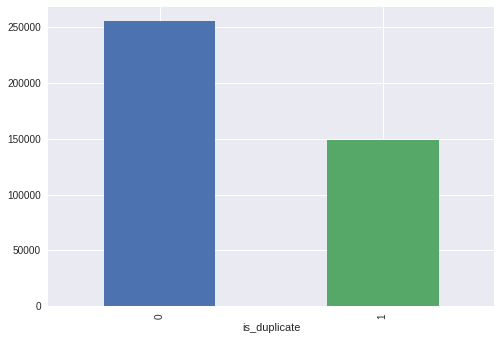

In [6]:
data.groupby('is_duplicate')['id'].count().plot.bar()

In [7]:
# EDA

#Checking for unique questions

qid = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique = len(np.unique(qid))
unique_morethan_onetime = np.sum(qid.value_counts() >1)

print('No. of uniques questions are : {}'.format(unique))

print('No. of questions repeated more than time : {}'.format(unique_morethan_onetime))

print('Max no. of times a single question is repeated : {}'.format(max(qid.value_counts())))

No. of uniques questions are : 537933
No. of questions repeated more than time : 111780
Max no. of times a single question is repeated : 157


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


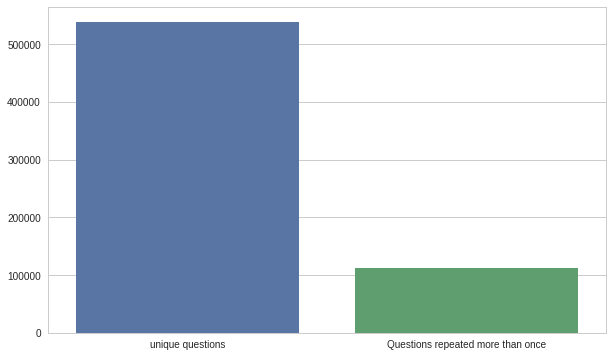

In [8]:
#plotting number of unique questions and number of questions repeated more than once using sns barplot
x = ['unique questions', 'Questions repeated more than once']
y = [unique, unique_morethan_onetime]

plt.figure(figsize = (10,6))
sns.set_style('whitegrid')
sns.barplot(x,y)
plt.show()

In [10]:
#Checking for nullvalues

null_rows = data[data.isnull().any(1)]
print(null_rows)

#filling null values with space
data = data.fillna(' ')

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [0]:
# Text Pre-processing (Different Method)

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
#beautiful soup is used for getting data from html tags    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [15]:
from fuzzywuzzy import fuzz
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


def extract_features(data):
    # preprocessing each question
    data["question1"] = data["question1"].fillna("").apply(preprocess)
    data["question2"] = data["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = data.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    data["cwc_min"]       = list(map(lambda x: x[0], token_features))
    data["cwc_max"]       = list(map(lambda x: x[1], token_features))
    data["csc_min"]       = list(map(lambda x: x[2], token_features))
    data["csc_max"]       = list(map(lambda x: x[3], token_features))
    data["ctc_min"]       = list(map(lambda x: x[4], token_features))
    data["ctc_max"]       = list(map(lambda x: x[5], token_features))
    data["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    data["first_word_eq"] = list(map(lambda x: x[7], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    data["token_set_ratio"]       = data.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    data["token_sort_ratio"]      = data.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    data["fuzz_ratio"]            = data.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    data["fuzz_partial_ratio"]    = data.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    return data

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [16]:
data = extract_features(data)
data.head(5)

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,86,63,66,75
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,63,63,43,47
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,28,24,9,14
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,67,47,35,56


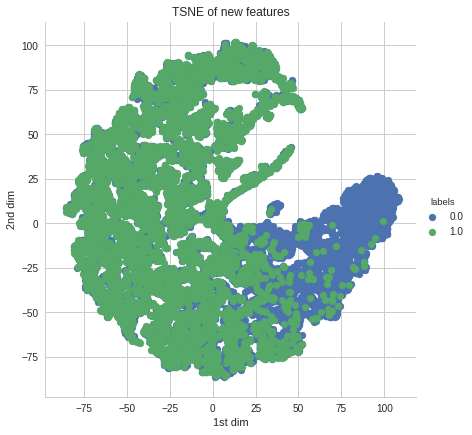

In [25]:
#Applying tsne on the new feature data

labels = data['is_duplicate']
labels_less = labels[0:20001]
data_15 = data[['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio']]
data_15_less = data_15.loc[0:20000, :]

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 60, n_iter = 2000, random_state = 1)

tsne_data = tsne.fit_transform(data_15_less)

tsne_data = np.vstack((tsne_data.T, labels_less)).T

#data massaging

df_tsne = pd.DataFrame(data = tsne_data, columns = ['1st dim', '2nd dim', 'labels'])

sns.set_style('whitegrid')
sns.FacetGrid(df_tsne, hue = 'labels', size = 6).map(plt.scatter, '1st dim', '2nd dim').add_legend()

plt.title('TSNE of new features')
plt.show()

In [27]:
# w2v on the data

lstq1 = []
lstq2 = []
for sent in data['question1'].values:
    wordsq1 =[]
    sent.split()
    for w in sent.split():
        wordsq1.append(w)
    lstq1.append(wordsq1)

for sent in data['question2'].values:
    wordsq2 =[]
    sent.split()
    for w in sent.split():
        wordsq2.append(w)
    lstq2.append(wordsq2)

#lstq1

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

q1_w2v_model = gensim.models.Word2Vec(lstq1, min_count = 2, size = 50, workers = 2)
q2_w2v_model = gensim.models.Word2Vec(lstq2, min_count = 2, size = 50, workers = 2)

q1_w2v_model.wv.most_similar('invest')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('earn', 0.682482898235321),
 ('raise', 0.674662172794342),
 ('mutual', 0.664311408996582),
 ('spend', 0.6594737768173218),
 ('invested', 0.6436182260513306),
 ('sell', 0.6392964720726013),
 ('start', 0.6384856104850769),
 ('investing', 0.6029826402664185),
 ('buy', 0.6020942330360413),
 ('visit', 0.6003199219703674)]

In [28]:
#Avg w2v of quesiton 1 & question2

sent_vectors_q1 = []
sent_vectors_q2 = []

for sent in lstq1:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = q1_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_q1.append(sent_vec)

for sent in lstq2:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = q2_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_q2.append(sent_vec)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [33]:
# Creating a new dataframe 
data['q1_vec'] = list(sent_vectors_q1)
data['q2_vec'] = list(sent_vectors_q2)

data2 = data.drop(['qid1','qid2','question1','question2'], axis = 1)
data2_q1 = pd.DataFrame(data2.q1_vec.values.tolist(), index= data2.index)
data2_q2 = pd.DataFrame(data2.q2_vec.values.tolist(), index= data2.index)

data2 = data2.drop(['q1_vec', 'q2_vec'], axis = 1)

data2_q1['id'] = data2['id']
data2_q2['id'] = data2['id']

data2_q1 = data2_q1.merge(data2_q2, on = 'id', how = 'left')
final_data = data2.merge(data2_q1, on = 'id', how = 'left')
final_data.head(2)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,-0.427158,0.100153,0.313464,-0.151404,0.121178,0.217344,-0.878303,-0.037308,0.472545,1.024481
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,-0.348837,-0.488191,0.169969,0.472078,0.408644,-0.468595,0.033370,-0.640003,0.191137,0.623920


In [34]:
# ML Modelling - data preparation

y = final_data['is_duplicate']
x = final_data.drop(['id', 'is_duplicate'], axis = 1)

x = x.fillna(method = 'ffill')
x = x.astype('int64')

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

x_tr, x_test, y_tr, y_test = cross_validation.train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 1)
x_tr.shape

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(323432, 112)

In [0]:
# Confusion matrix

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
    C = confusion_matrix(y_test, y_pred)
    
    #precision matrix
    A = (C/C.sum(axis = 0))
    
    
    #recall matrix
    B = ((C.T)/(C.sum(axis = 1))).T
    
    
    labels = [1,2]
    #plotting confusion matrix
    plt.figure(figsize = (20,7))
    sns.set_style('whitegrid')
    sns.heatmap(C, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted class')
    plt.ylabel('Actual Class')
    plt.show()
    
    #plotting precision matrix
    plt.figure(figsize = (20,7))
    sns.set_style('whitegrid')
    sns.heatmap(A, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
    plt.title('Precision Matrix (sum(axis = 0) = 1)')
    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    plt.show()
    
    #plotting recall matrix
    plt.figure(figsize = (20,7))
    sns.set_style('whitegrid')
    sns.heatmap(B, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
    plt.title('Recall Matrix (sum(axis = 1) = 1)')
    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    plt.show()

Log loss of the random model on test is : 0.8859954137564243


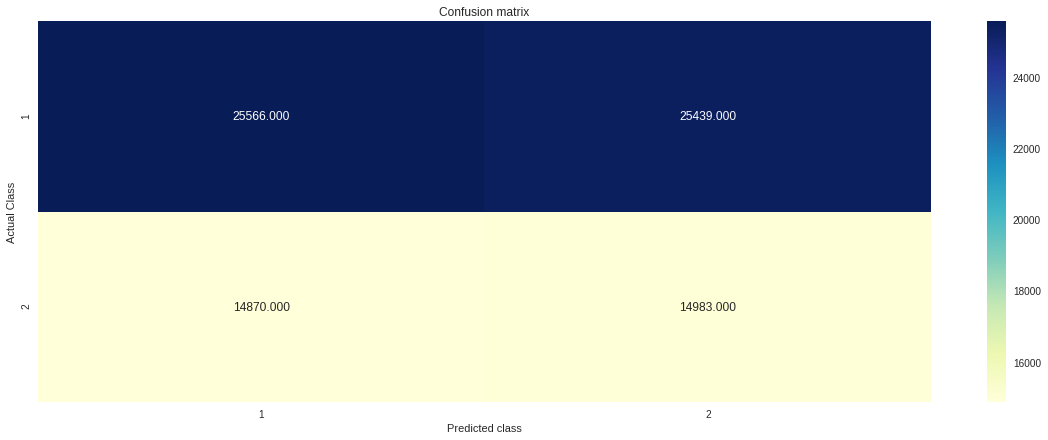

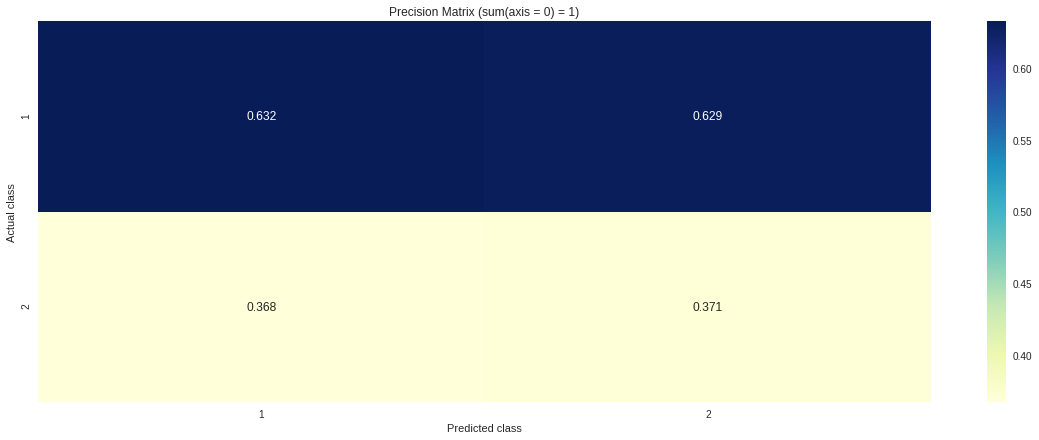

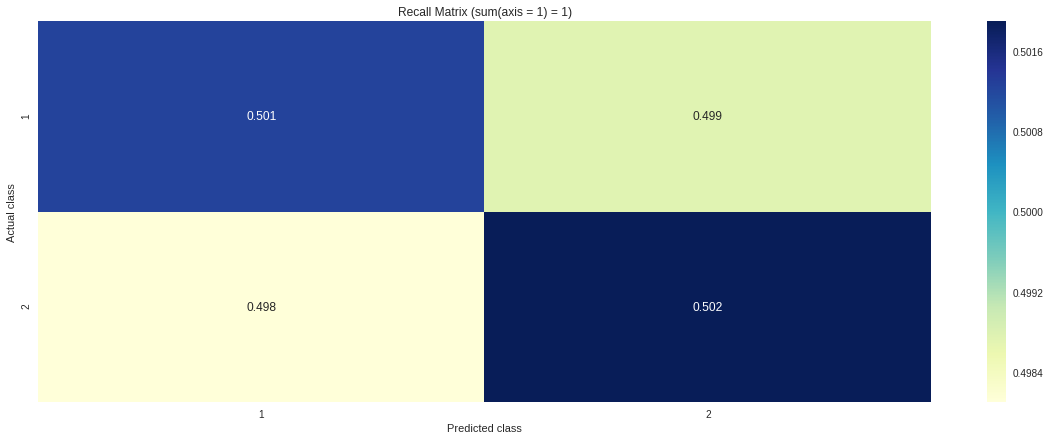

In [36]:
#Random Model 

#creating an output array of y_test_pred

y_test_len = len(y_test)

#same size of y_test_pred
y_test_pred = np.zeros((y_test_len, 2))

for i in range(y_test_len):
    random_probs = np.random.rand(1,2)
    y_test_pred[i] = ((random_probs/sum(sum(random_probs)))[0])

print('Log loss of the random model on test is : {}'.format(log_loss(y_test, y_test_pred, eps = 1e-15)))


pred_y = np.argmax(y_test_pred, axis = 1)
plot_confusion_matrix(y_test, pred_y)

Observation - Random model gives a log loss of ~0.88 which  is the worst log loss this data sets can have

Log Loss of logistic resgression on test data is 0.5063478841190995


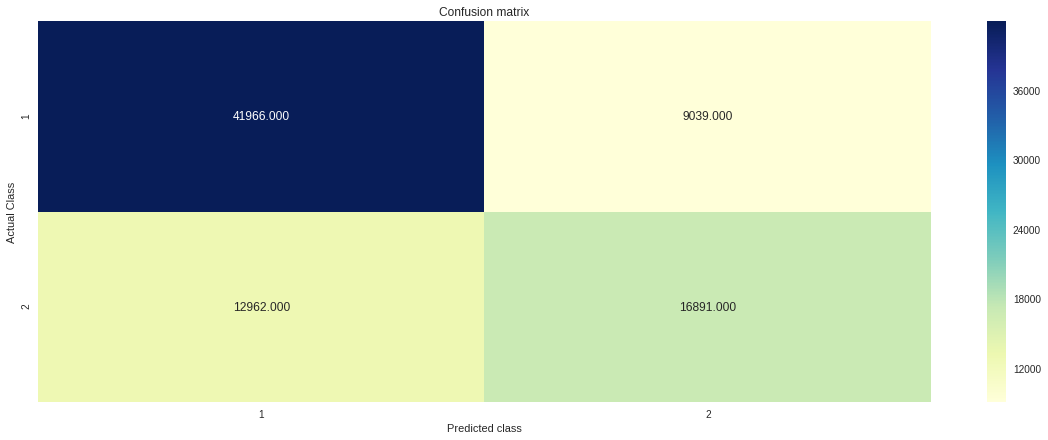

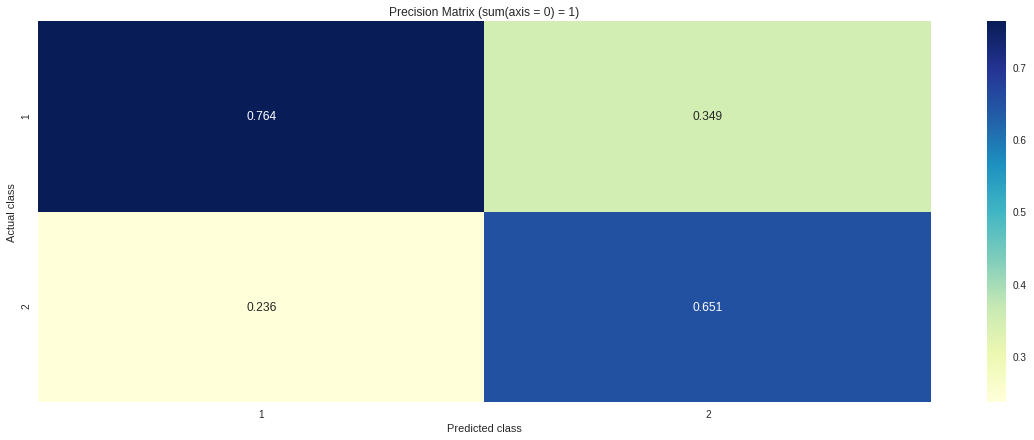

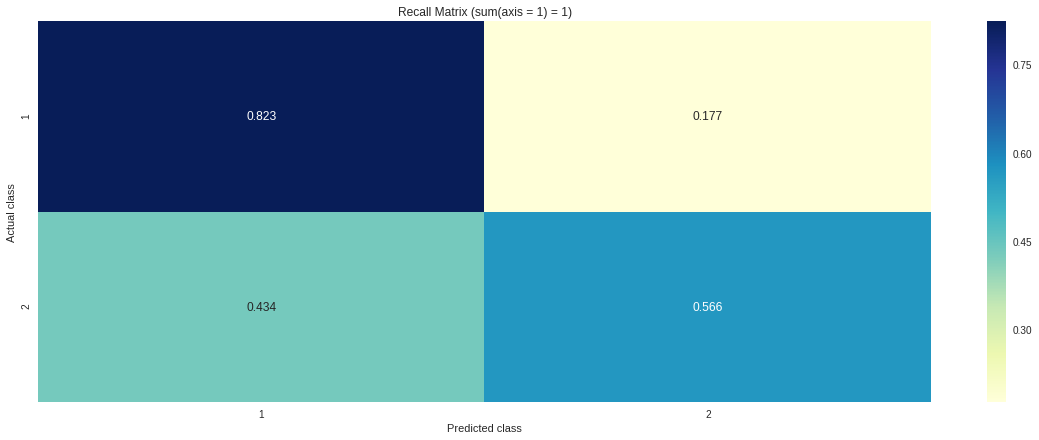

No. of misclassified points are 0.27209428875312275


In [37]:
#Applying Logistic Regression and CalibratedClassifierCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

tuned_param = { 'C' : np.random.rand(100)}

rand = RandomizedSearchCV(LogisticRegression(), tuned_param, scoring = 'neg_log_loss')
rand.fit(x_tr, y_tr)

lor = LogisticRegression(C = 0.25, penalty = 'l2')
lor.fit(x_tr, y_tr)
clf = CalibratedClassifierCV(lor, method = 'sigmoid')
clf.fit(x_tr, y_tr)

pred_y = clf.predict_proba(x_test)
test_log_loss = log_loss(y_test, pred_y, labels = clf.classes_, eps = 1e-15) 
print('Log Loss of logistic resgression on test data is {}'.format(test_log_loss))

plot_confusion_matrix(y_test, clf.predict(x_test))

msc = np.count_nonzero((clf.predict(x_test) - y_test))/ y_test.shape[0]
print('No. of misclassified points are {}'.format(msc))

Observation - Logistic regression does a good job in classifying the points as its log loss has come out to be of 0.50 which is coniderably less than the worst log loss this data set. It classifies 27% of points wrongly.